# Main Script



#### Needed Imports

In [ ]:
%pip install -U seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


#### Loading data from data_loader.py

In [ ]:
# CSV zip folder's path
csv_file_name = 'train.csv'

# loading data from csv
data = pd.read_csv(csv_file_name)

---
#### Data Acquisition

#### Describing data

In [ ]:
#print shape of dataset
print("Dataset shape:",data.shape) #25175 row, 91 columns. We know that the label Y ('year) is the first one column.

# saving data without first column 'year'
no_target_column_data = data[data.columns[1:]]
print(no_target_column_data.describe())

Dataset shape: (1220, 91)
                S0           S1           S2           S3           S4  \
count  1220.000000  1220.000000  1220.000000  1220.000000  1220.000000   
mean     43.493212     4.046516     9.126229     0.661107    -7.173465   
std       6.034532    48.661225    35.881884    15.671477    21.767997   
min      19.549220  -237.656380  -162.594680   -57.008120   -95.095450   
25%      39.942330   -21.175800   -10.850243    -8.519148   -21.003200   
50%      44.381380    10.592280    11.424135    -1.116110    -6.792920   
75%      47.981282    36.358587    31.306722     7.995793     7.248077   
max      55.746630   225.421310   188.016920   111.246940    95.557380   

                S5           S6           S7           S8           S9  ...  \
count  1220.000000  1220.000000  1220.000000  1220.000000  1220.000000  ...   
mean     -9.576147    -2.414806    -1.948389     3.591243     1.760459  ...   
std      13.025299    14.298516     8.106648    10.514693     6.560538

#### Data by target column 'Year'

Sono presenti righe con categorie della colonna target 'Year' che vanno dal 1956 al 2009.

C'è uno sbilanciamento del dataset, che presenta molte più righe (e per cui canzoni e features su cui verranno allenati i modelli) per gli anni dal (circa) 1990 in poi.

Infatti, nel dataset per il 1990 stesso ci sono 3628 righe, per il 2000 ce ne sono più di 9mila e per il 2009 (anno maggiore == più vicino nel tempo all'anno odierno) ce ne sono più di 15mila.
In generale per gli anni 2000 ci sono circa più di 10mila righe, per gli altri, allontanandosi sempre più indietro nel tempo, ce ne sono sempre meno fino a toccare un minimodi circa 200 / 300.

E' necessario bilanciare il dataset o comunque affidare dei pesi ad ogni categoria / classe in modo tale che il training sia bilanciato in base ai dati a nostra disposizione.

**Oversampling:** <br>
*Vantaggi:*
- Preserva tutte le informazioni replicando o generando nuove istanze per le classi sottorappresentate.
- Potenziale miglioramento delle prestazioni del modello, specialmente con dati limitati.<br>
*Svantaggi:*
- Rischio di overfitting, soprattutto con oversampling eccessivo.
- Aumento del costo computazionale a causa dell'ingrandimento del dataset.

**Downsampling:**<br>
*Vantaggi:*
- Riduce il sovraccarico computazionale diminuendo il numero di istanze della classe sovra-rappresentata.
- Minimizza il rischio di overfitting attraverso la riduzione del numero di istanze.<br>
*Svantaggi:*
- Possibile perdita di informazioni eliminando istanze.
- Rischio di sottorappresentare classi importanti.
<br>
**Scelta tra Oversampling e Downsampling:** <br>
La scelta dipende dal contesto. Sperimentare entrambe le tecniche potrebbe essere utile, valutando gli effetti collaterali e cercando di mantenere un equilibrio tra le classi nel dataset senza introdurre bias indesiderati.

In [ ]:
sorted_data_by_year = data.sort_values(by='Year')

year_count = sorted_data_by_year['Year'].value_counts()
print(year_count.sort_index())

1956     3
1957     1
1958     2
1959     2
1961     2
1962     1
1963     4
1964     3
1965     1
1966     4
1968     1
1969     2
1970    10
1971     5
1972     6
1973     7
1974     7
1975    11
1976     6
1977     7
1978     8
1979    12
1980     7
1981     9
1982    14
1983     7
1984     4
1985     5
1986    10
1987    18
1988    10
1989    20
1990    21
1991    25
1992    17
1993    25
1994    37
1995    28
1996    37
1997    45
1998    38
1999    41
2000    29
2001    56
2002    49
2003    64
2004    77
2005    97
2006    85
2007    96
2008    76
2009    68
Name: Year, dtype: int64


In [ ]:
infos=sorted_data_by_year.groupby('Year')
print(infos.describe())

        S0                                                                  \
     count       mean       std       min        25%        50%        75%   
Year                                                                         
1956   3.0  37.188257  6.280872  31.63498  33.780025  35.925070  39.964895   
1957   1.0  27.256080       NaN  27.25608  27.256080  27.256080  27.256080   
1958   2.0  46.717770  4.579040  43.47990  45.098835  46.717770  48.336705   
1959   2.0  42.768525  0.330594  42.53476  42.651643  42.768525  42.885407   
1961   2.0  38.733645  8.233672  32.91156  35.822603  38.733645  41.644687   
1962   1.0  47.234390       NaN  47.23439  47.234390  47.234390  47.234390   
1963   4.0  38.711282  2.682319  34.72365  38.342970  39.866310  40.234623   
1964   3.0  43.917480  2.169722  41.59337  42.931305  44.269240  45.079535   
1965   1.0  44.633650       NaN  44.63365  44.633650  44.633650  44.633650   
1966   4.0  40.387518  8.471555  32.31245  34.242920  39.171015 

---
#### Data visualization

##### Density plot

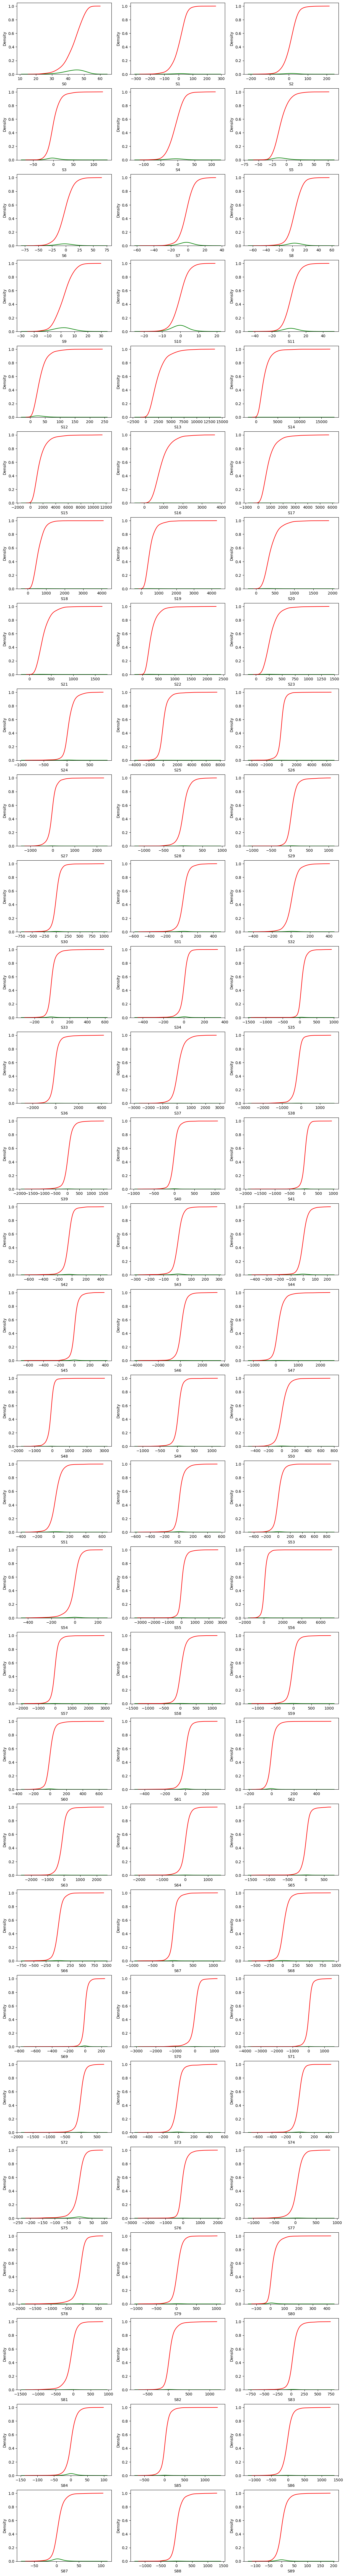

In [ ]:
# Density plot
fig, axs = plt.subplots(30, 3, figsize=(15, 120))
counter = 0

for i in range(30):
  for j in range(3):

    # Plot KDE
    sns.kdeplot(no_target_column_data.iloc[:,counter], ax=axs[i, j], color='g', bw_adjust=2, label='Smooth factor=2')

    # Plot CDF
    sns.kdeplot(no_target_column_data.iloc[:,counter], ax=axs[i, j], color='r', cumulative=True, label='CDF')

    axs[i, j].set_xlabel("S" + str(counter))
    counter = counter+1

plt.show()


Dal density plot notiamo come non sia presente una distribuzione gaussiana dei dati.

##### Box plot

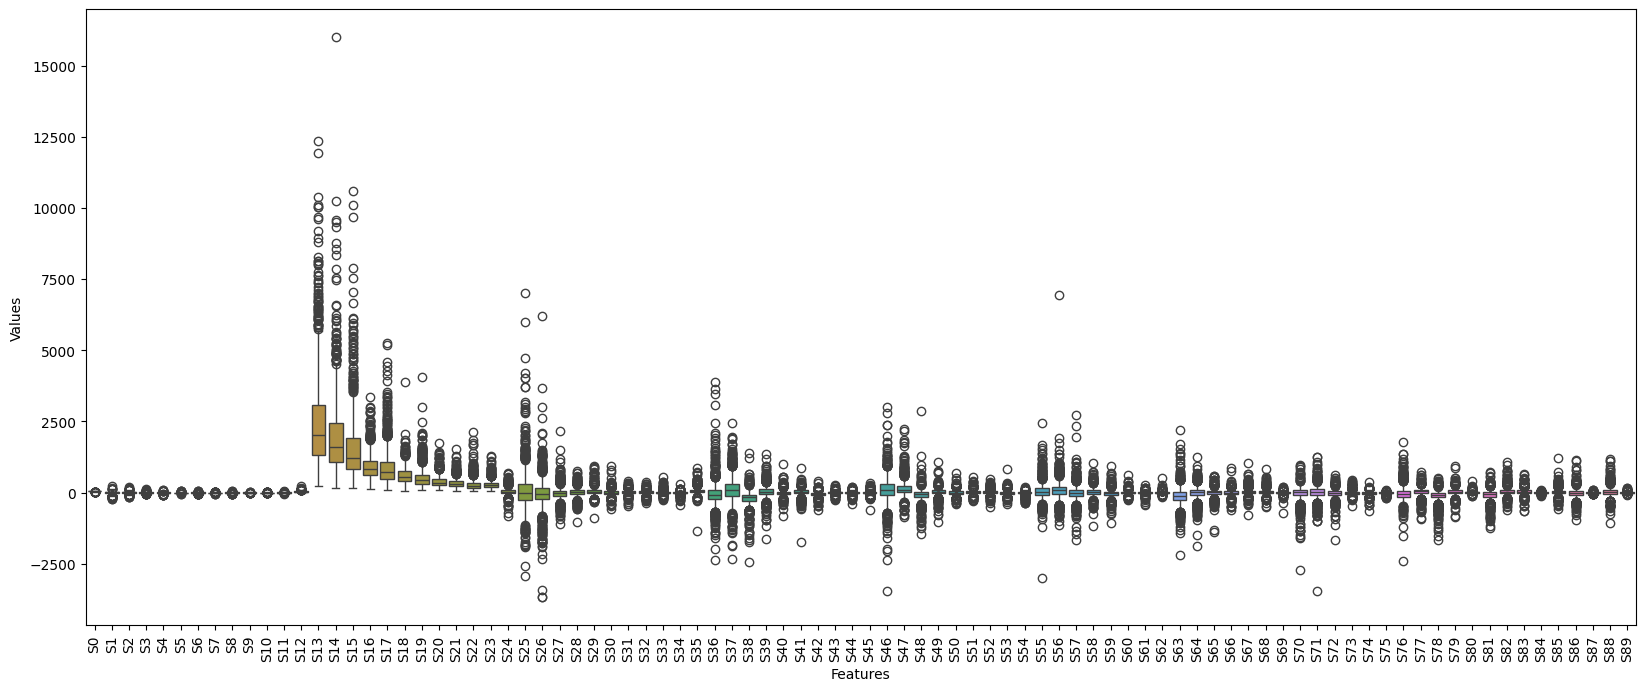

In [ ]:
# Box plot
plt.figure(figsize=(20, 8))
sns.boxplot(data=no_target_column_data, orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

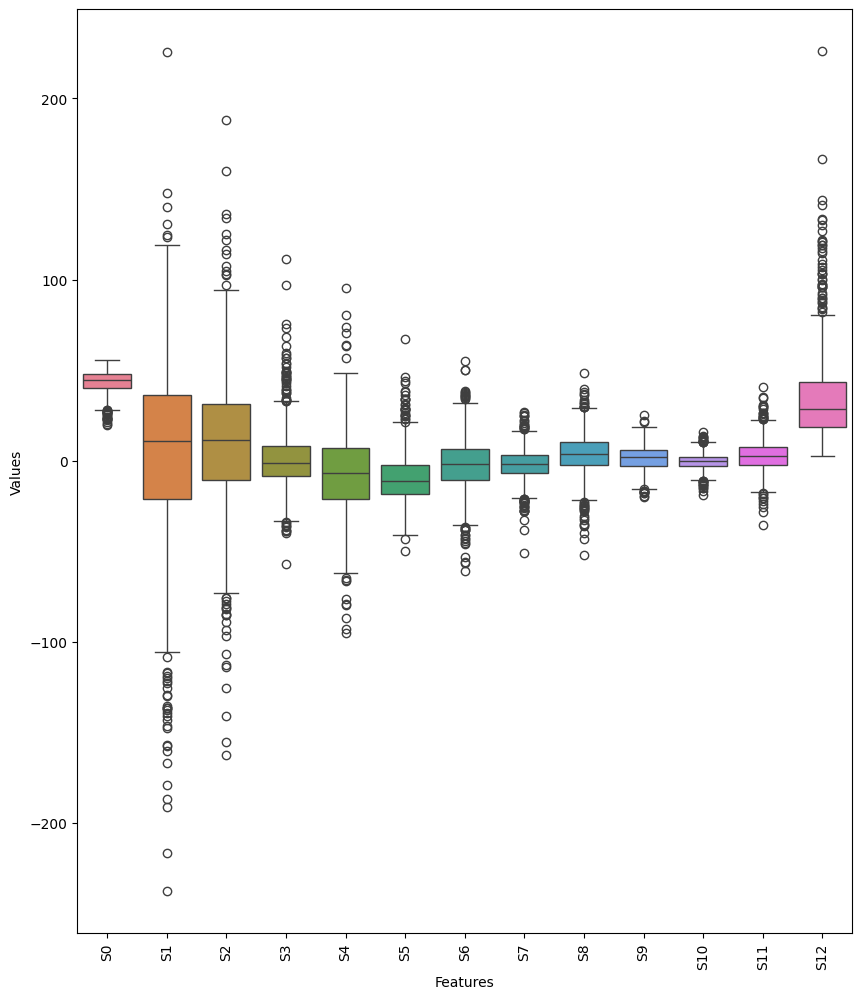

In [ ]:
# Box plot S0 to S12
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,0:13], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

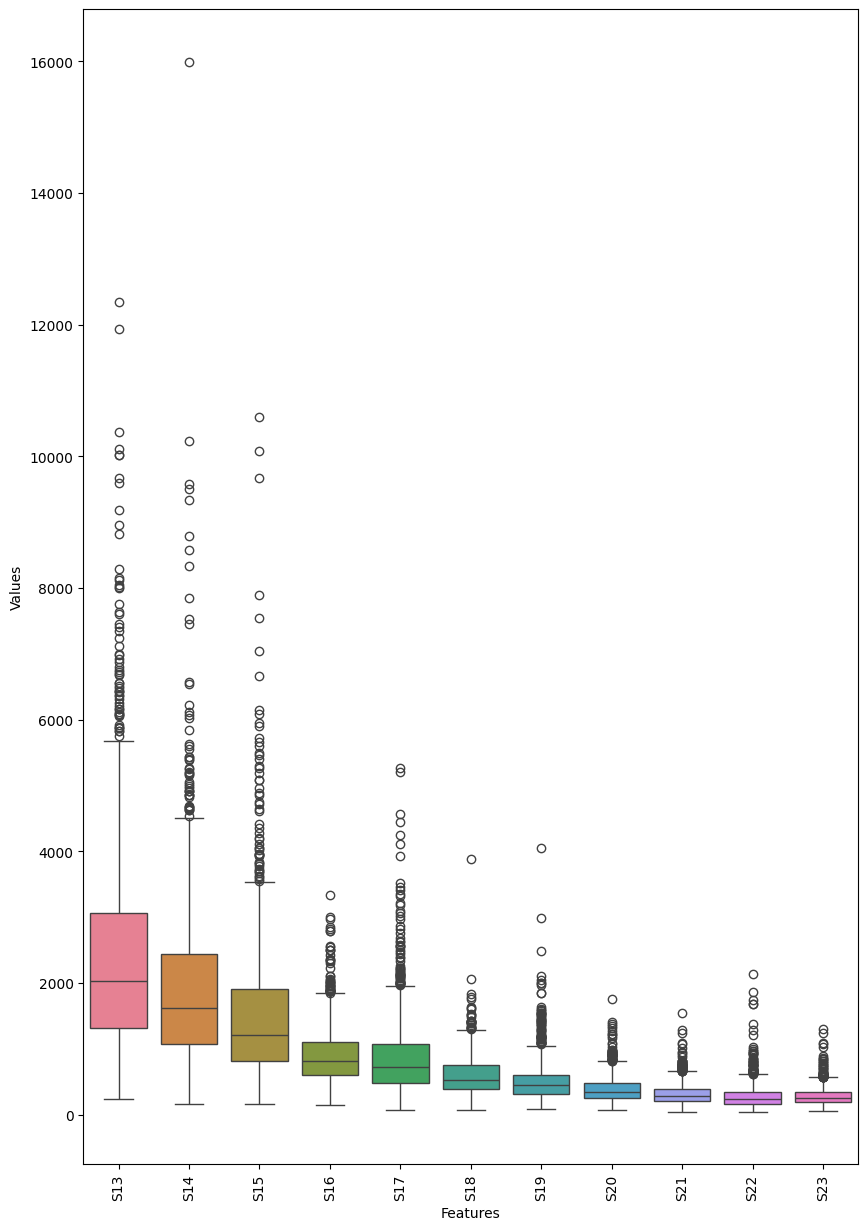

In [ ]:
# Box plot S13 to S23
plt.figure(figsize=(10, 15))
sns.boxplot(data=no_target_column_data.iloc[:,13:24], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

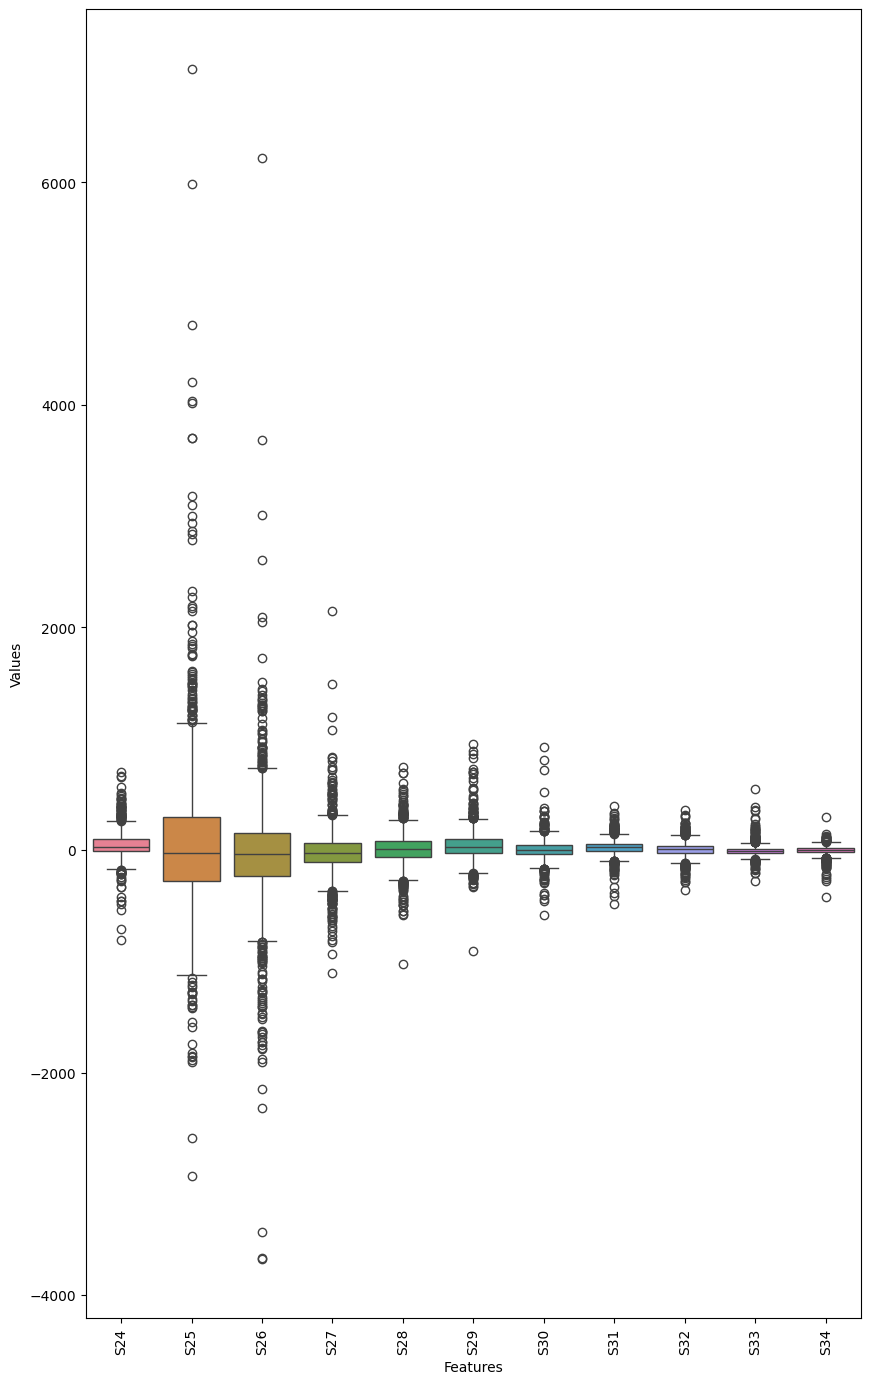

In [ ]:
# Box plot S24 to S34
plt.figure(figsize=(10, 17))
sns.boxplot(data=no_target_column_data.iloc[:,24:35], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

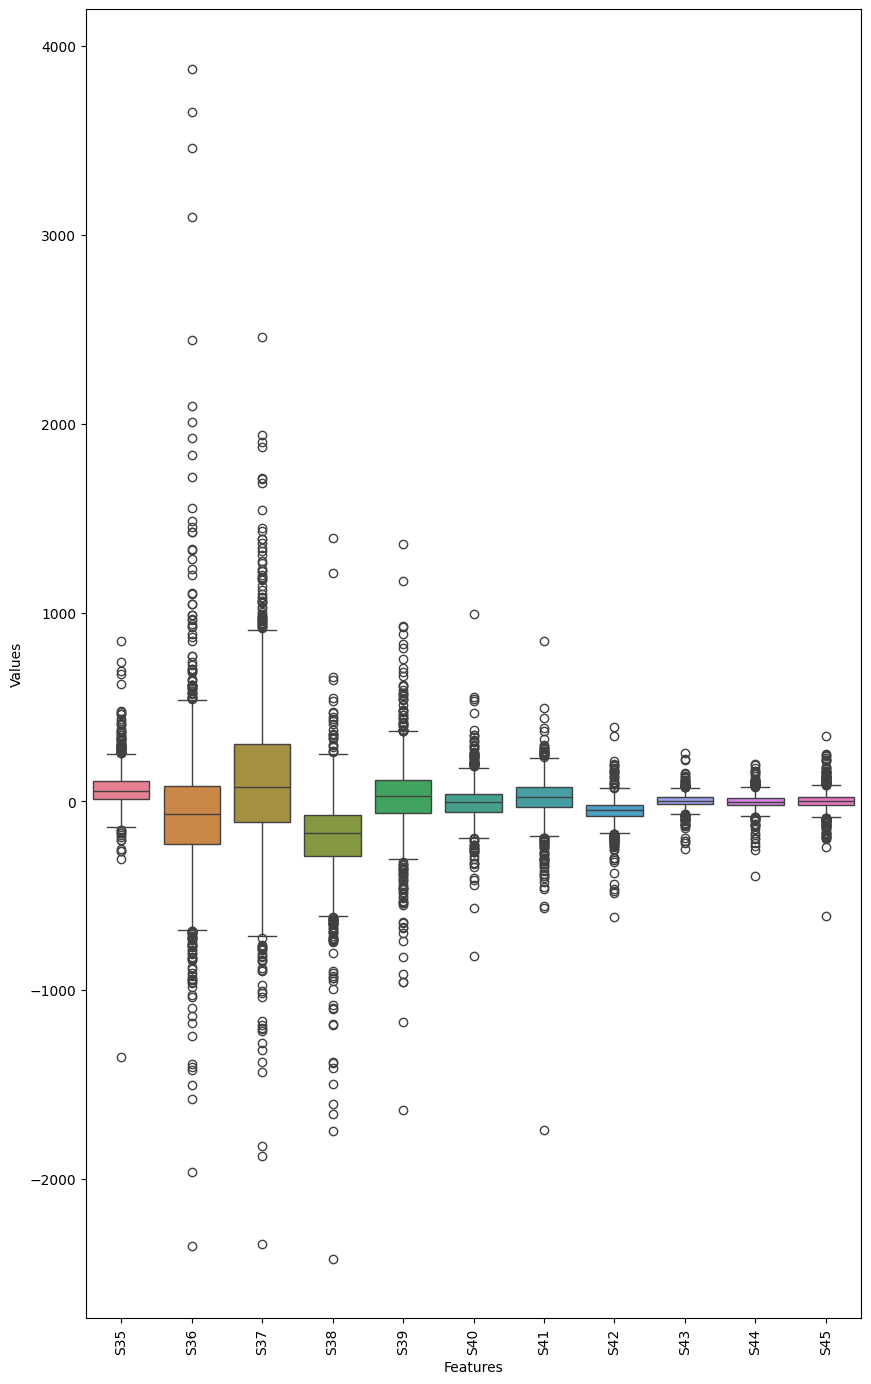

In [ ]:
# Box plot S35 to S45
plt.figure(figsize=(10, 17))
sns.boxplot(data=no_target_column_data.iloc[:,35:46], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

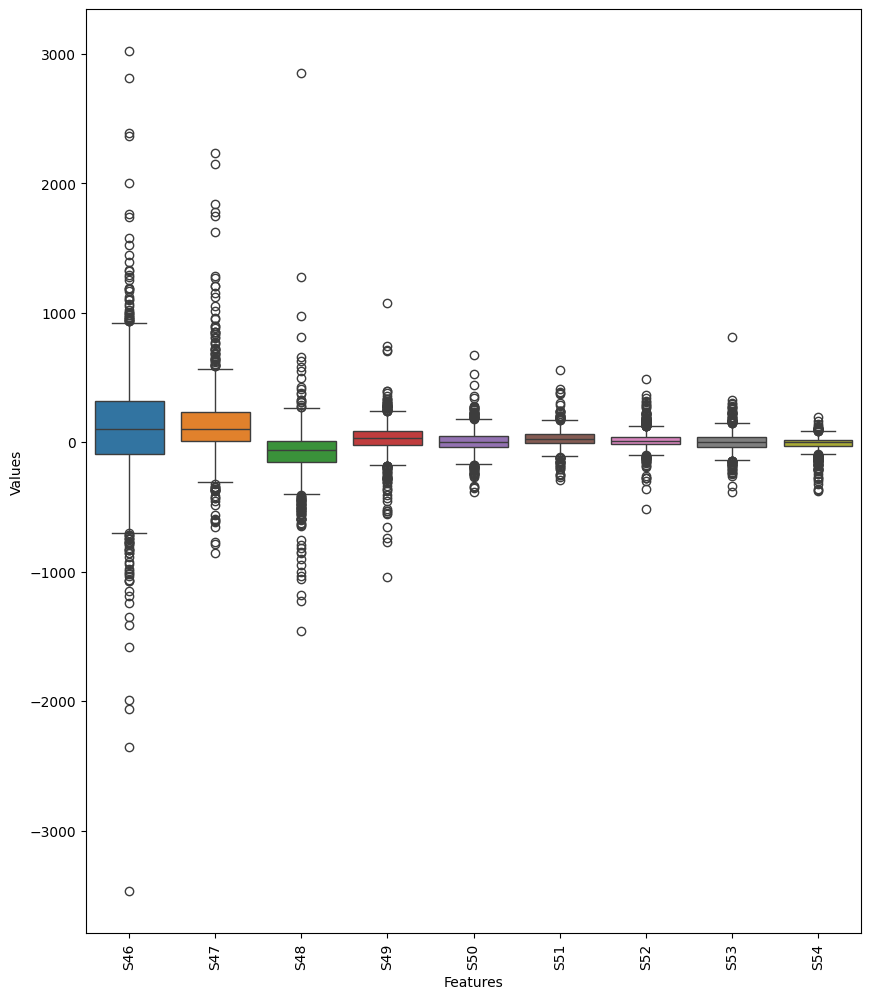

In [ ]:
# Box plot S46 to S54
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,46:55], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

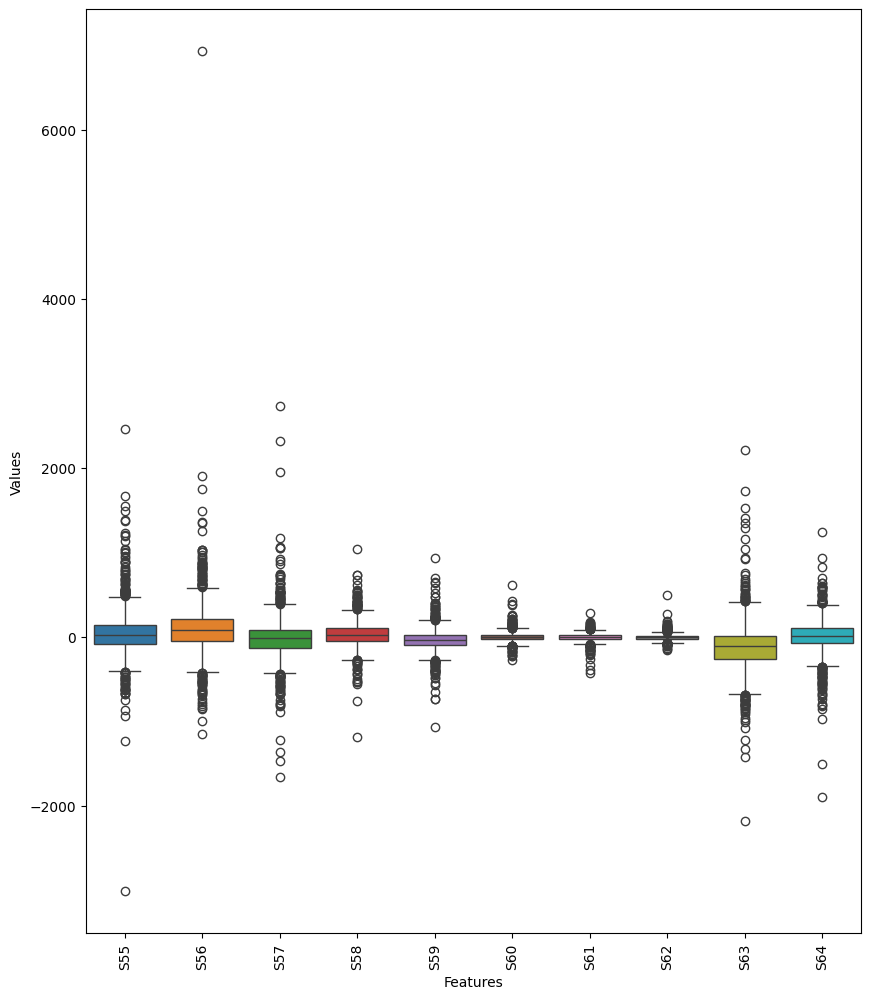

In [ ]:
# Box plot S55 to S64
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,55:65], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

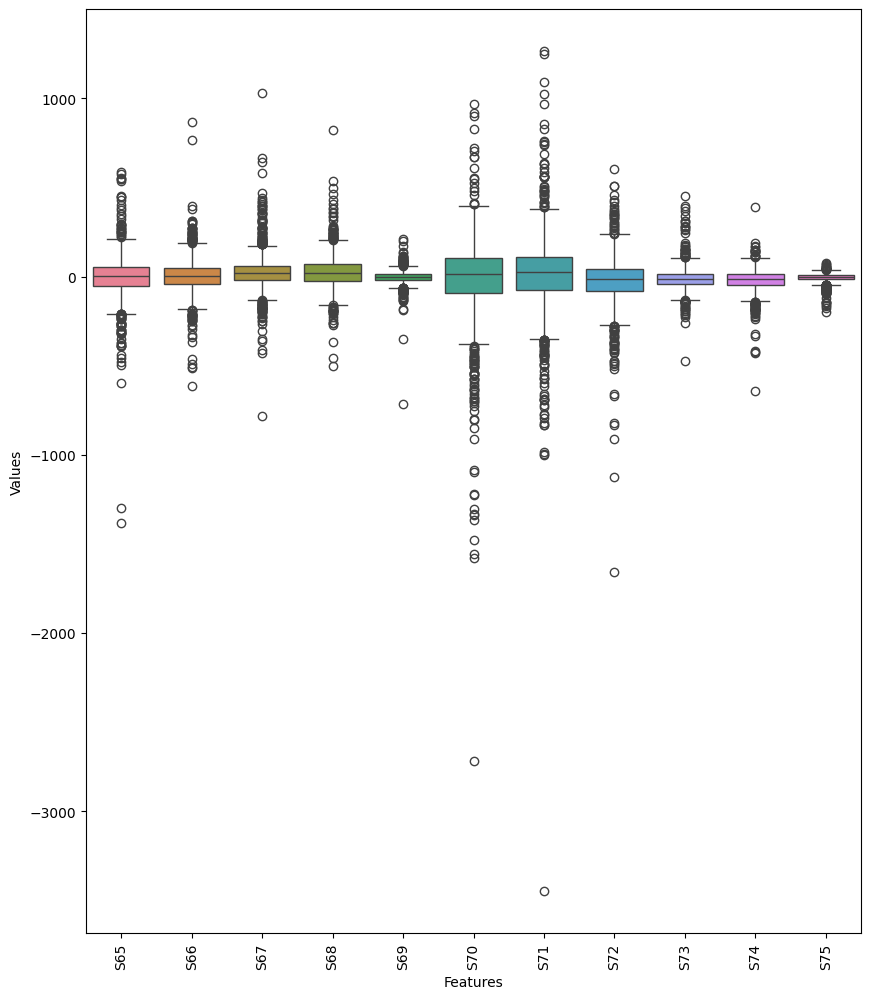

In [ ]:
# Box plot S65 to S75
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,65:76], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

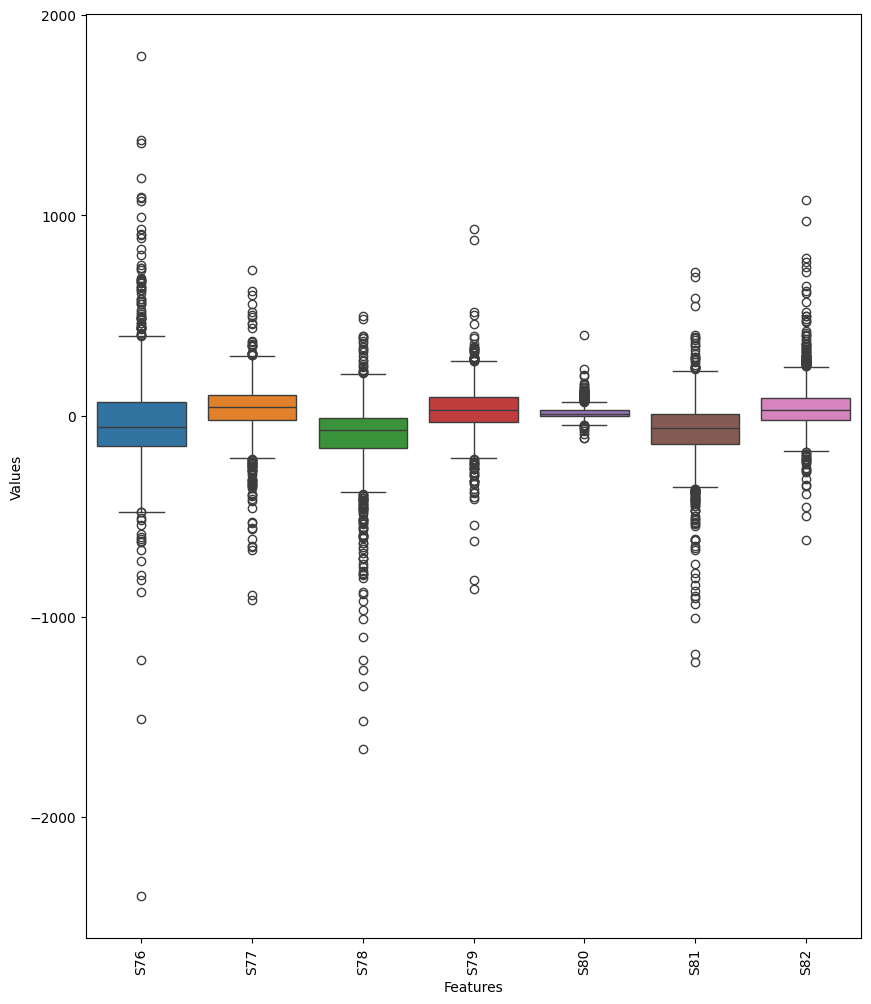

In [ ]:
# Box plot S76 to S82
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,76:83], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

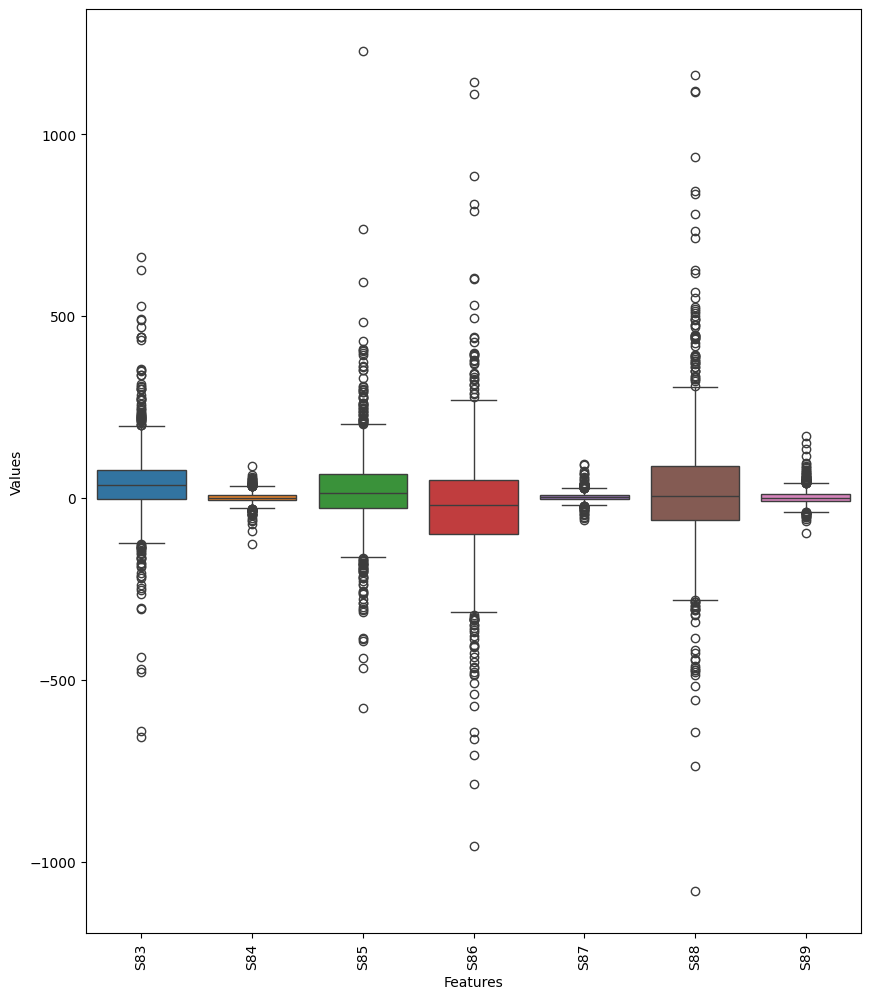

In [ ]:
# Box plot S83 to S89
plt.figure(figsize=(10, 12))
sns.boxplot(data=no_target_column_data.iloc[:,83:90], orient='v')  # orient='v' indica un boxplot verticale

# Aggiunta di etichette all'asse x
plt.xticks(rotation=90)  # Puoi regolare l'angolo di inclinazione delle etichette per una migliore leggibilità

# Titoli e etichette degli assi
plt.xlabel('Features')
plt.ylabel('Values')

# Visualizzazione del boxplot
plt.show()

Nei **Boxplots** che abbiamo mostrato qua sopra, si possono notare come le features hanno una distribuzione di dati simile per quasi tutte le colonne, tranne per quelle che vanno da: *S0* a *S12*. Sono presenti, per ogni features, un gran numero di *outliers* sia sotto i valori minimi sia sopra i valori massimi del boxplot.

Da questo deduciamo 2 strade percorribili:

1. Mantenere il dataset senza trattare gli *outliers*: questi valori potrebbere essere importanti in cui siano delle caratteristiche specifiche e rilevanti per la canzone.

2. Trattare gli *outliers*: consideriamo quindi che non siano rilevanti per l'allenamento del nostro modello, ma si tratti di dati rumorosi e fuorvianti.

Valutare problema di **High Dimensionality**: tramite PCA (Princial Component Analysis) e LDA (Linear Discrimination Analysis)

Valutare **Normalizzazione**: vedeondo la distribuzione non gaussiana, opterei per **MinMaxScaling** (non escludere *Standardization*)



---
#### Data Preprocessing (necessary for the task)


---
#### Data Modeling (tuning hyperparams)


---
#### Performance Evaluation
